[2025-11-26 11:30:55] YOLO LR Finder 開始...
DATA_YAML = /NFS/celine/aicup/yoloNew/data9010.yaml
MODEL     = /NFS/celine/aicup/yoloNew/runs/detect/heart_valve_detector_nano1026/weights/best.pt
CANDIDATES= [0.003, 0.01, 0.02, 0.03]
------------------------------------------------------------
▶ 掃描 lr0=0.003 ...
Ultralytics 8.3.232 🚀 Python-3.10.14 torch-2.5.1+cu124 CUDA:0 (NVIDIA TITAN RTX, 24210MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/NFS/celine/aicup/yoloNew/data9010.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=

2025-11-26 11:30:55,938	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-26 11:30:56,231	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2689536  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512

NameError: name 'best_lr' is not defined

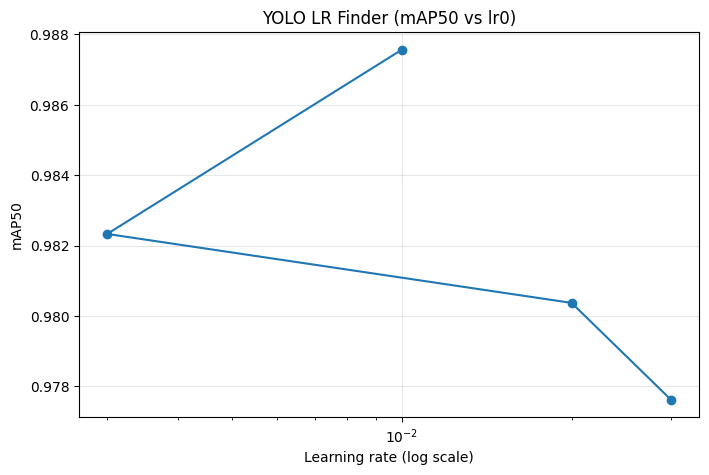

In [1]:
# lr_finder.py
import os, csv, glob, math, time
from datetime import datetime
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ========= 可調參數 =========
DATA_YAML   = "/NFS/celine/aicup/yoloNew/data9010.yaml" 
MODEL_PATH  = "/NFS/celine/aicup/yoloNew/runs/detect/heart_valve_detector_nano1021/weights/best.pt"  
#MODEL_PATH  = "/NFS/celine/aicup/yoloNew/runs/detect/heart_valve_detector_nano1026/weights/best.pt"
LR_CANDIDATES = [3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]  
#LR_CANDIDATES = [3e-3, 1e-2, 2e-2, 3e-2]
EPOCHS_SHORT = 5
IMG_SIZE     = 512
BATCH_SIZE   = 16
OPTIMIZER    = "SGD"
COS_LR       = True      # 想單看初始 lr0 影響可設 False
PATIENCE     = 0         # 極短訓練別早停
DEVICE       = 0         # 改成 'cpu' 也可以
NAME_PREFIX  = "lrscan_s"  # run 名稱前綴
# ==========================

def read_results_csv(save_dir):
    """
    從 Ultralytics 的 results.csv 讀取最後一行（最後一個 epoch）指標。
    回傳 dict（若讀取失敗回 None）。
    """
    csv_path = os.path.join(save_dir, "results.csv")
    if not os.path.exists(csv_path):
        return None

    last_row = None
    with open(csv_path, "r", newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            last_row = row

    if last_row is None:
        return None

    # 常見欄位（不同版本命名可能略有不同，盡量兼容）
    def get_float(key, default=math.nan):
        for k in [key, key.replace("(B)", ""), key.replace("(", "_").replace(")", "")]:
            if k in last_row and last_row[k] != "":
                try:
                    return float(last_row[k])
                except ValueError:
                    pass
        return default

    metrics = {
        "epoch":      get_float("epoch", math.nan),
        "mAP50":      get_float("metrics/mAP50(B)", get_float("metrics/mAP50")),
        "mAP50-95":   get_float("metrics/mAP50-95(B)", get_float("metrics/mAP50-95")),
        "precision":  get_float("metrics/precision(B)", get_float("metrics/precision")),
        "recall":     get_float("metrics/recall(B)", get_float("metrics/recall")),
        "val_box":    get_float("val/box_loss"),
        "val_cls":    get_float("val/cls_loss"),
        "val_dfl":    get_float("val/dfl_loss"),
        "train_box":  get_float("train/box_loss"),
        "train_cls":  get_float("train/cls_loss"),
        "train_dfl":  get_float("train/dfl_loss"),
    }
    return metrics

def train_once(lr0):
    """
    用指定 lr0 做極短訓練，回傳 (save_dir, metrics_dict)。
    """
    run_name = f"{NAME_PREFIX}_lr{lr0:g}"
    model = YOLO(MODEL_PATH)

    results = model.train(
        data=DATA_YAML,
        epochs=EPOCHS_SHORT,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        optimizer=OPTIMIZER,
        lr0=lr0,
        patience=PATIENCE,
        cos_lr=COS_LR,
        single_cls=True,     # 你是單一類別
        device=DEVICE,
        verbose=False,
        plots=False,
        name=run_name,
       
    )

    # 取得儲存目錄
    save_dir = None
    # 新版通常有 save_dir
    if hasattr(results, "save_dir") and results.save_dir:
        save_dir = str(results.save_dir)
    else:
        # 備案：從 runs/detect 底下找 run_name
        # （task 可能是 detect/seg/cls，這裡先以 detect 為主）
        candidates = glob.glob(os.path.join("runs", "*", run_name))
        save_dir = candidates[0] if candidates else None

    metrics = read_results_csv(save_dir) if save_dir else None
    return save_dir, metrics

def main():
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] YOLO LR Finder 開始...")
    print(f"DATA_YAML = {DATA_YAML}")
    print(f"MODEL     = {MODEL_PATH}")
    print(f"CANDIDATES= {LR_CANDIDATES}")
    print("-" * 60)

    rows = []
    for lr in LR_CANDIDATES:
        print(f"▶ 掃描 lr0={lr:g} ...")
        try:
            save_dir, metrics = train_once(lr)
            if metrics is None:
                print(f"  無法讀取 results.csv（run 目錄：{save_dir}），略過。")
                continue
            row = {
                "lr0": lr,
                "save_dir": save_dir,
                "epoch": metrics["epoch"],
                "mAP50": metrics["mAP50"],
                "mAP50-95": metrics["mAP50-95"],
                "precision": metrics["precision"],
                "recall": metrics["recall"],
                "val_box": metrics["val_box"],
                "val_cls": metrics["val_cls"],
                "val_dfl": metrics["val_dfl"],
            }
            rows.append(row)
            print(f"  mAP50={row['mAP50']:.4f}, val_box={row['val_box']:.4f}, dir={save_dir}")
        except Exception as e:
            print(f"  lr0={lr:g} 發生例外：{e}")

    if not rows:
        print("沒有可用結果，請檢查訓練是否成功或調整設定。")
        return

    # 排名：mAP50 由大到小、若相近則 val_box 越小越前
    rows.sort(key=lambda r: (-(r["mAP50"] if r["mAP50"]==r["mAP50"] else -1), (r["val_box"] if r["val_box"]==r["val_box"] else 1e9)))

    # 輸出 CSV 與 Markdown
    csv_out = "lrscan_summary.csv"
    md_out  = "lrscan_summary.md"
    headers = ["rank","lr0","mAP50","mAP50-95","precision","recall","val_box","val_cls","val_dfl","epoch","save_dir"]

    with open(csv_out, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(headers)
        for i, r in enumerate(rows, 1):
            w.writerow([
                i, r["lr0"], r["mAP50"], r["mAP50-95"], r["precision"], r["recall"],
                r["val_box"], r["val_cls"], r["val_dfl"], r["epoch"], r["save_dir"]
            ])

    with open(md_out, "w", encoding="utf-8") as f:
        f.write("| " + " | ".join(headers) + " |\n")
        f.write("|" + "|".join(["---"]*len(headers)) + "|\n")
        for i, r in enumerate(rows, 1):
            f.write("| " + " | ".join([
                str(i),
                f"{r['lr0']:g}",
                f"{r['mAP50']:.4f}" if r["mAP50"]==r["mAP50"] else "nan",
                f"{r['mAP50-95']:.4f}" if r["mAP50-95"]==r["mAP50-95"] else "nan",
                f"{r['precision']:.4f}" if r["precision"]==r["precision"] else "nan",
                f"{r['recall']:.4f}" if r["recall"]==r["recall"] else "nan",
                f"{r['val_box']:.4f}" if r["val_box"]==r["val_box"] else "nan",
                f"{r['val_cls']:.4f}" if r["val_cls"]==r["val_cls"] else "nan",
                f"{r['val_dfl']:.4f}" if r["val_dfl"]==r["val_dfl"] else "nan",
                f"{int(r['epoch'])}" if r["epoch"]==r["epoch"] else "nan",
                r["save_dir"] or ""
            ]) + " |\n")

    best = rows[0]
    print("-" * 60)
    print("完成！排行榜（Top 3）：")
    for i, r in enumerate(rows[:3], 1):
        print(f"#{i} lr0={r['lr0']:g} | mAP50={r['mAP50']:.4f} | val_box={r['val_box']:.4f} | dir={r['save_dir']}")
    print("-" * 60)
    print(f"建議起始 lr0 = {best['lr0']:g}")
    print(f"已輸出：{csv_out}, {md_out}")
    print("可直接開啟 lrscan_curve.png 觀察曲線。")
    
    # ============= 繪圖 =============
    plt.figure(figsize=(8,5))
    x = [r["lr0"] for r in rows]
    y = [r["mAP50"] for r in rows]
    plt.plot(x, y, marker="o")
    plt.xscale("log")
    plt.xlabel("Learning rate (log scale)")
    plt.ylabel("mAP50")
    plt.title("YOLO LR Finder (mAP50 vs lr0)")
    plt.grid(True, alpha=0.3)

    plt.scatter([best_lr], [best["mAP50"]], color="red", s=80, label=f"Best lr0={best_lr:g}")
    plt.legend()
    out_img = "lrscan_curve.png"
    plt.tight_layout()
    plt.savefig(out_img, dpi=200)
    plt.close()

    


if __name__ == "__main__":
    main()


In [11]:
#rows.sort(key=lambda r: (-(r["mAP50"] if r["mAP50"]==r["mAP50"] else -1), (r["val_box"] if r["val_box"]==r["val_box"] else 1e9)))
rows.sort(key=lambda r: (-(r["mAP50"] if r["mAP50"]==r["mAP50"] else -1)))
print("-" * 60)
print("完成！排行榜（Top 3）：")
for i, r in enumerate(rows[:3], 1):
    #print(f"#{i} lr0={r['lr0']:g} | mAP50={r['mAP50']:.4f} | val_box={r['val_box']:.4f} | dir={r['save_dir']}")
    print(f"#{i} lr0={r['lr0']:g} | mAP50={r['mAP50']:.4f} ")
print("-" * 60)
print(f"建議起始 lr0 = {best['lr0']:g}")
print(f"已輸出：{csv_out}, {md_out}")
print("可直接開啟 lrscan_curve.png 觀察曲線。")

------------------------------------------------------------
完成！排行榜（Top 3）：
#1 lr0=0.01 | mAP50=0.9876 
#2 lr0=0.02 | mAP50=0.9840 


TypeError: unsupported format string passed to NoneType.__format__

NameError: name 'best_lr' is not defined

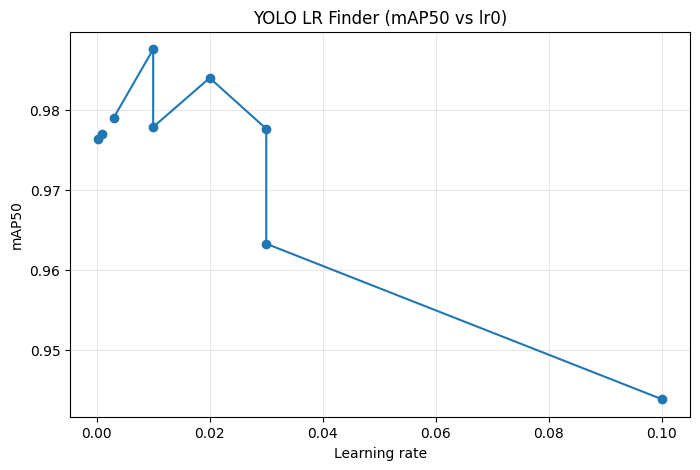

In [2]:
import os, glob, pandas as pd
import matplotlib.pyplot as plt

rows = []
for run_dir in sorted(glob.glob('runs/detect/lrscan_s_*')):
    csv = os.path.join(run_dir, 'results.csv')
    hyp = os.path.join(run_dir, 'args.yaml')  # 也可讀出 lr0
    if os.path.exists(csv):
        df = pd.read_csv(csv)
        # 取最佳 mAP@50（不同版本欄位名可能是 metrics/mAP50 或 mAP50）
        col = 'metrics/mAP50(B)' if 'metrics/mAP50(B)' in df.columns else 'mAP50'
        best_map50 = df[col].max()
        # 讀 lr0（你也可把 lr0 事先存在檔名或另存一份）
        lr0 = None
        if os.path.exists(hyp):
            import yaml; lr0 = yaml.safe_load(open(hyp)) .get('lr0', None)
        rows.append({'run': run_dir, 'lr0': lr0, 'mAP50': best_map50})

# 繪圖
plt.figure(figsize=(8,5))
x = [r["lr0"] for r in rows]
y = [r["mAP50"] for r in rows]
plt.plot(x, y, marker="o")
#plt.xscale("log")
#plt.xlabel("Learning rate (log scale)")
plt.xlabel("Learning rate")
plt.ylabel("mAP50")
plt.title("YOLO LR Finder (mAP50 vs lr0)")
plt.grid(True, alpha=0.3)

plt.scatter([best_lr], [best["mAP50"]], color="red", s=80, label=f"Best lr0={best_lr:g}")
plt.legend()
out_img = "lrscan_curve.png"
plt.tight_layout()
plt.savefig(out_img, dpi=200)
plt.close()
#rows = sorted(rows, key=lambda r: (r['lr0'] is None, r['lr0']))
#xs = [r['lr0'] for r in rows if r['lr0'] is not None]
#ys = [r['mAP50'] for r in rows if r['lr0'] is not None]
#plt.figure(figsize=(8,5))
#plt.plot(xs, ys, marker='o')
#plt.xlabel('lr0'); plt.ylabel('best mAP@0.5'); plt.title('LR scan curve')
#plt.grid(True); plt.tight_layout()
#plt.savefig('lrscan_curve.png', dpi=150)
#print("已輸出 lrscan_curve.png")


In [6]:
for i, r in enumerate(rows):
    if "val_box" not in r:
        print("缺 val_box 的 row 編號 =", i)
        print("內容 =", r)
        break


缺 val_box 的 row 編號 = 0
內容 = {'run': 'runs/detect/lrscan_s_lr0.00034', 'lr0': 0.0003, 'mAP50': 0.97635}
